In [1]:
import numpy as np
from numpy import ndarray
import os
from ase.io import read, iread
from ase.neighborlist import build_neighbor_list
from ase import Atoms
from itertools import combinations_with_replacement
from tqdm import tqdm_notebook
import sys
%matplotlib inline

In [2]:
def read_poscars(pfile, step=1):
    structures = []
    counter = 0
    with open(pfile, 'r') as f:
        lines = f.readlines()
        for i, line in enumerate(lines):
            if 'EA' in line:
                if counter % step == 0:
                    current_struct = []
                    num_of_atoms = sum([int(item) for item in lines[i+6].split()])
                    for line in lines[i:i+8+num_of_atoms+1]:
                        current_struct.append(line)
                    coef = float(current_struct[1])
                    cell = np.ndarray(shape=(3,3))
                    species = current_struct[5].split()
                    num_species = [int(item) for item in current_struct[6].split()]                    
                    symbols = np.repeat(species, num_species)
                    if 'Selective Dynamics' in current_struct:
                        raise NotImplementedError
                    positions = np.ndarray(shape=(num_of_atoms,3))
                    for j in range(3):
                        cell[j] = np.asarray(current_struct[j+2].split(), dtype=float)
                    cell *= coef
                    for n in range(num_of_atoms):
                        positions[n] = np.asarray(current_struct[n+8].split(), dtype=float)
                    if 'Direct' in current_struct[7]:
                        positions = np.dot(positions, cell)
                    ID = int(current_struct[0].split('EA')[-1])
                    structure = Atoms(symbols=symbols, positions=positions, cell=cell, pbc=True)
                    structure.ID = ID
                    structures.append(structure)
                counter += 1
    return structures

In [3]:
poscars = './POSCARS'
energies = np.loadtxt('./Energies_TOTEN', dtype=float)
structures = read_poscars(poscars)

In [5]:
import time
X = []
Names = []
startTime = time.time()
for iStep, struct in enumerate(structures):
    n1 = build_neighbor_list(struct, cutoffs = len(struct.positions)*[2], bothways=True, self_interaction=False, skin=0.0)
    DistNeigh = np.array([])
    for iAtom in range(len(struct.positions)):
        indices, offsets = n1.get_neighbors(iAtom)
        atomPos = struct.positions[iAtom]
        neighPos = struct.positions[indices] + offsets @ struct.get_cell()
        distNeig = np.linalg.norm(neighPos - atomPos, axis=1)
        DistNeigh = np.append(DistNeigh, distNeig)

    rPowerVal = 16
    reCutVal = 8
    rePowVal = 11
    Features = np.zeros(rPowerVal + reCutVal*rePowVal)
    iIter = 0
    for iPower in np.arange(1, 9, 0.5):
        Features[iIter] = np.sum((1/DistNeigh)**iPower)
        iIter += 1
        if iStep == 0:
            name = 'rijPow=-%.1f'%iPower
            Names.append(name)
    for iRc in np.arange(0.5, 4.5, 0.5):
        for jPow in np.arange(1,6.5,0.5):
            Features[iIter] = np.sum(np.exp(-(DistNeigh/iRc)**jPow))
            iIter += 1
            if iStep == 0:
                name = 'rc=%.1f epow=%.1f'%(iRc, jPow)
                Names.append(name)
    X.append(Features)
    if (iStep % 500 == 0) & (iStep != 0):
        print("%i done out of %i ; Time: %.1f"%(iStep, len(structures),(time.time()-startTime)))
X = np.array(X)

500 done out of 4972 ; Time: 5.0
1000 done out of 4972 ; Time: 10.0
1500 done out of 4972 ; Time: 14.9
2000 done out of 4972 ; Time: 19.8
2500 done out of 4972 ; Time: 24.6
3000 done out of 4972 ; Time: 29.4
3500 done out of 4972 ; Time: 34.2
4000 done out of 4972 ; Time: 39.0
4500 done out of 4972 ; Time: 43.7


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

Y = energies
X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=0.3)

#нормировка данных, так как далее будет использоваться градиентный спуск
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [9]:
from sklearn.metrics import mean_squared_error as mse
# "Learn" the mean from the training data
mean_train = np.mean(y_train)
# Get predictions on the test set
baseline_predictions = np.ones(y_test.shape) * mean_train
# Compute MSE
mse_baseline = mse(y_test, baseline_predictions)
print("Baseline rMSE is {:.2f}".format(np.sqrt(mse_baseline)))

Baseline rMSE is 5.86


In [10]:
# xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.05,
#                 max_depth = 20, alpha = 10, n_estimators = 2000)

params = {
    # Parameters that we are going to tune.
    'max_depth':10,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
}

params['eval_metric'] = "rmse"
num_boost_round = 999
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)
print("Best rMSE: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

[0]	Test-rmse:4.27553
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:3.02146
[2]	Test-rmse:2.20930
[3]	Test-rmse:1.64015
[4]	Test-rmse:1.23208
[5]	Test-rmse:0.96058
[6]	Test-rmse:0.78424
[7]	Test-rmse:0.67178
[8]	Test-rmse:0.60762
[9]	Test-rmse:0.56612
[10]	Test-rmse:0.53968
[11]	Test-rmse:0.52387
[12]	Test-rmse:0.51612
[13]	Test-rmse:0.50915
[14]	Test-rmse:0.50670
[15]	Test-rmse:0.50375
[16]	Test-rmse:0.50125
[17]	Test-rmse:0.50056
[18]	Test-rmse:0.50035
[19]	Test-rmse:0.50001
[20]	Test-rmse:0.49977
[21]	Test-rmse:0.49945
[22]	Test-rmse:0.49895
[23]	Test-rmse:0.49889
[24]	Test-rmse:0.49837
[25]	Test-rmse:0.49831
[26]	Test-rmse:0.49849
[27]	Test-rmse:0.49845
[28]	Test-rmse:0.49837
[29]	Test-rmse:0.49822
[30]	Test-rmse:0.49815
[31]	Test-rmse:0.49822
[32]	Test-rmse:0.49822
[33]	Test-rmse:0.49821
[34]	Test-rmse:0.49820
[35]	Test-rmse:0.49822
[36]	Test-rmse:0.49821
[37]	Test-rmse:0.49819
[38]	Test-rmse:0.49822
[39]	Test-rmse:0.49822
[40]	Test-rmse:0.49821
Stopping. 

In [11]:
params = {
    # Parameters that we are going to tune.
    'max_depth':10,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
}

num_boost_round = 999


cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=10
)

cv_results

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0          4.334127        0.088225        4.354150       0.387433
1          3.111002        0.061904        3.149490       0.309071
2          2.244613        0.042564        2.290179       0.246381
3          1.626604        0.029291        1.685310       0.192512
4          1.187123        0.019726        1.266322       0.149226
5          0.874696        0.012338        0.985631       0.117413
6          0.650743        0.009184        0.797522       0.088444
7          0.487347        0.006692        0.674627       0.069218
8          0.367866        0.005287        0.593972       0.061183
9          0.280698        0.004753        0.543153       0.059033
10         0.215774        0.004309        0.512359       0.063124
11         0.167476        0.003664        0.494050       0.065138
12         0.132008        0.003291        0.483833       0.067564
13         0.105134        0.002458        0.477346       0.067556
14         0.084584        0.001495        0.474510       0.067814
15         0.069253        0.001860        0.471404       0.067891
16         0.057149        0.001942        0.469971       0.068701
17         0.048105        0.002027        0.468549       0.068897
18         0.040722        0.002112        0.468172       0.069528
19         0.035441        0.001908        0.467556       0.069987
20         0.030883        0.001667        0.467178       0.070067
21         0.027245        0.001633        0.467218       0.070533
22         0.024425        0.001400        0.466995       0.070678
23         0.022257        0.001308        0.467001       0.070737
24         0.020393        0.001427        0.466942       0.070684

In [12]:
cv_results['test-rmse-mean'].argmin()

24

In [13]:
# You can try wider intervals with a larger step between
# each value and then narrow it down. Here after several
# iteration I found that the optimal value was in the
# following ranges.
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(3,9)
    for min_child_weight in range(3,9)
]

In [14]:
# Define initial best params and rMSE
min_rmse = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best rMSE
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, rMSE: {}".format(best_params[0], best_params[1], min_rmse))

CV with max_depth=3, min_child_weight=3
	rMSE 0.48704920000000007 for 96 rounds
CV with max_depth=3, min_child_weight=4
	rMSE 0.4901578000000001 for 73 rounds
CV with max_depth=3, min_child_weight=5
	rMSE 0.5462466 for 90 rounds
CV with max_depth=3, min_child_weight=6
	rMSE 0.5665312 for 50 rounds
CV with max_depth=3, min_child_weight=7
	rMSE 0.5310278 for 180 rounds
CV with max_depth=3, min_child_weight=8
	rMSE 0.5560278000000001 for 42 rounds
CV with max_depth=4, min_child_weight=3
	rMSE 0.47160019999999997 for 32 rounds
CV with max_depth=4, min_child_weight=4
	rMSE 0.47011000000000003 for 39 rounds
CV with max_depth=4, min_child_weight=5
	rMSE 0.5287257999999999 for 26 rounds
CV with max_depth=4, min_child_weight=6
	rMSE 0.5551102 for 17 rounds
CV with max_depth=4, min_child_weight=7
	rMSE 0.5483663999999999 for 32 rounds
CV with max_depth=4, min_child_weight=8
	rMSE 0.595026 for 25 rounds
CV with max_depth=5, min_child_weight=3
	rMSE 0.46386479999999997 for 19 rounds
CV with max_de

In [15]:
params['max_depth'] = 6
params['min_child_weight'] = 4

In [16]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(5,11)]
    for colsample in [i/10. for i in range(5,11)]
]

In [17]:
min_rmse = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample,colsample)
print("Best params: {}, {}, rMSE: {}".format(best_params[0], best_params[1], min_rmse))

CV with subsample=1.0, colsample=1.0
	rMSE 0.4556958000000001 for 26 rounds
CV with subsample=1.0, colsample=0.9
	rMSE 0.4628254 for 16 rounds
CV with subsample=1.0, colsample=0.8
	rMSE 0.4556514 for 36 rounds
CV with subsample=1.0, colsample=0.7
	rMSE 0.45333560000000006 for 17 rounds
CV with subsample=1.0, colsample=0.6
	rMSE 0.45059459999999996 for 26 rounds
CV with subsample=1.0, colsample=0.5
	rMSE 0.45765580000000006 for 16 rounds
CV with subsample=0.9, colsample=1.0
	rMSE 0.4678188 for 15 rounds
CV with subsample=0.9, colsample=0.9
	rMSE 0.4724526 for 16 rounds
CV with subsample=0.9, colsample=0.8
	rMSE 0.4685144 for 17 rounds
CV with subsample=0.9, colsample=0.7
	rMSE 0.45205839999999997 for 24 rounds
CV with subsample=0.9, colsample=0.6
	rMSE 0.44487259999999995 for 21 rounds
CV with subsample=0.9, colsample=0.5
	rMSE 0.452911 for 16 rounds
CV with subsample=0.8, colsample=1.0
	rMSE 0.49395619999999996 for 14 rounds
CV with subsample=0.8, colsample=0.9
	rMSE 0.4846130000000000

In [18]:
params['subsample'] = 0.9
params['colsample_bytree'] = 0.6

In [19]:
import time

min_rmse = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    startTime = time.time()
    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            seed=42,
            nfold=5,
            metrics=['rmse'],
            early_stopping_rounds=10)
    print("Time: %.2f s"%(time.time()-startTime))
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trMSE {} for {} rounds\n".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = eta
print("Best params: {}, rMSE: {}".format(best_params, min_rmse))

CV with eta=0.3
Time: 0.96 s
	rMSE 0.44487259999999995 for 21 rounds

CV with eta=0.2
Time: 1.22 s
	rMSE 0.4065758 for 25 rounds

CV with eta=0.1
Time: 2.03 s
	rMSE 0.4135318 for 58 rounds

CV with eta=0.05
Time: 4.44 s
	rMSE 0.4119065999999999 for 143 rounds

CV with eta=0.01
Time: 19.55 s
	rMSE 0.4089552 for 643 rounds

CV with eta=0.005
Time: 30.57 s
	rMSE 0.4159396 for 998 rounds

Best params: 0.2, rMSE: 0.4065758


In [20]:
params['eta'] = 0.01

In [21]:
params

{'max_depth': 6,
 'min_child_weight': 4,
 'eta': 0.01,
 'subsample': 0.9,
 'colsample_bytree': 0.6,
 'objective': 'reg:squarederror'}

In [22]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-rmse:5.86662
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:5.81193
[2]	Test-rmse:5.75616
[3]	Test-rmse:5.70277
[4]	Test-rmse:5.64576
[5]	Test-rmse:5.59191
[6]	Test-rmse:5.54014
[7]	Test-rmse:5.48642
[8]	Test-rmse:5.43566
[9]	Test-rmse:5.38434
[10]	Test-rmse:5.33445
[11]	Test-rmse:5.28508
[12]	Test-rmse:5.23417
[13]	Test-rmse:5.18638
[14]	Test-rmse:5.13735
[15]	Test-rmse:5.09010
[16]	Test-rmse:5.03956
[17]	Test-rmse:4.99319
[18]	Test-rmse:4.94719
[19]	Test-rmse:4.90212
[20]	Test-rmse:4.85348
[21]	Test-rmse:4.80900
[22]	Test-rmse:4.76441
[23]	Test-rmse:4.71920
[24]	Test-rmse:4.67575
[25]	Test-rmse:4.63101
[26]	Test-rmse:4.58856
[27]	Test-rmse:4.54430
[28]	Test-rmse:4.50276
[29]	Test-rmse:4.46117
[30]	Test-rmse:4.41802
[31]	Test-rmse:4.37601
[32]	Test-rmse:4.33571
[33]	Test-rmse:4.29584
[34]	Test-rmse:4.25513
[35]	Test-rmse:4.21605
[36]	Test-rmse:4.17693
[37]	Test-rmse:4.13851
[38]	Test-rmse:4.09987
[39]	Test-rmse:4.06251
[40]	Test-rmse:4.02518
[41]	Test-

[344]	Test-rmse:0.53586
[345]	Test-rmse:0.53461
[346]	Test-rmse:0.53332
[347]	Test-rmse:0.53202
[348]	Test-rmse:0.53079
[349]	Test-rmse:0.52956
[350]	Test-rmse:0.52837
[351]	Test-rmse:0.52726
[352]	Test-rmse:0.52603
[353]	Test-rmse:0.52492
[354]	Test-rmse:0.52382
[355]	Test-rmse:0.52287
[356]	Test-rmse:0.52164
[357]	Test-rmse:0.52055
[358]	Test-rmse:0.51952
[359]	Test-rmse:0.51856
[360]	Test-rmse:0.51745
[361]	Test-rmse:0.51665
[362]	Test-rmse:0.51562
[363]	Test-rmse:0.51455
[364]	Test-rmse:0.51364
[365]	Test-rmse:0.51257
[366]	Test-rmse:0.51155
[367]	Test-rmse:0.51069
[368]	Test-rmse:0.50980
[369]	Test-rmse:0.50891
[370]	Test-rmse:0.50811
[371]	Test-rmse:0.50718
[372]	Test-rmse:0.50626
[373]	Test-rmse:0.50544
[374]	Test-rmse:0.50465
[375]	Test-rmse:0.50394
[376]	Test-rmse:0.50316
[377]	Test-rmse:0.50237
[378]	Test-rmse:0.50138
[379]	Test-rmse:0.50057
[380]	Test-rmse:0.49986
[381]	Test-rmse:0.49906
[382]	Test-rmse:0.49832
[383]	Test-rmse:0.49760
[384]	Test-rmse:0.49684
[385]	Test-rmse:

[686]	Test-rmse:0.44297
[687]	Test-rmse:0.44295
[688]	Test-rmse:0.44292
[689]	Test-rmse:0.44291
[690]	Test-rmse:0.44291
[691]	Test-rmse:0.44294
[692]	Test-rmse:0.44297
[693]	Test-rmse:0.44298
Stopping. Best iteration:
[683]	Test-rmse:0.44290



<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

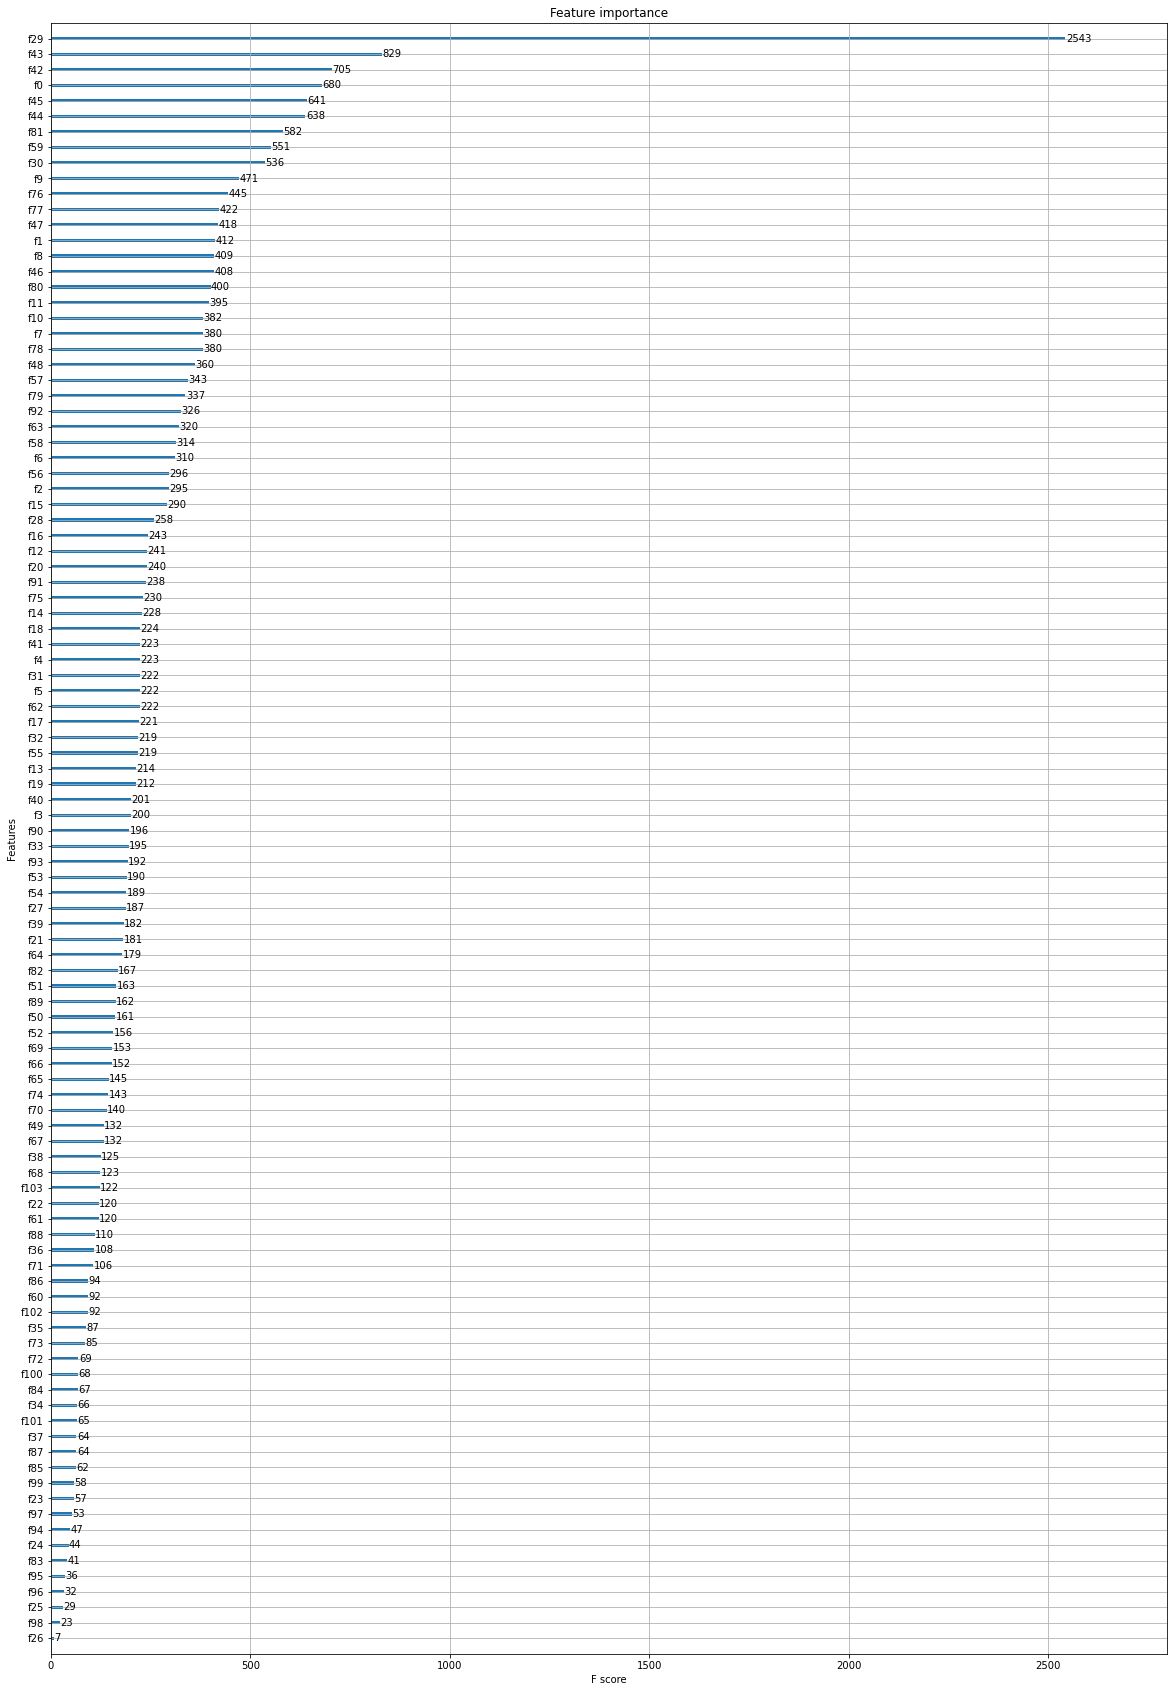

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,30)) 
xgb.plot_importance(model, ax=plt.gca())

In [24]:
model.save_model("model_Miryashkin_1.0.model")

# #loading xgboost model
# loaded_model = xgb.Booster()
# loaded_model.load_model("my_model_1.0.model")

# # And use it for predictions.
# ypred = loaded_model.predict(dtest)